In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

import comet_ml

2023-01-10 12:49:23.916015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Set the seed value for experiment reproducibility.
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
# Set the seed value for experiment reproducibility. Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [5]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

#Train & Validation Split 
train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='data_cleaned/Train',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='data_cleaned/Train',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

#Organize data for our predictions 
image_generator_prediction = ImageDataGenerator(rescale=1/255) 
prediction_data = image_generator_prediction.flow_from_directory(
                                                 directory='data_cleaned/scraped_images',
                                                 shuffle=False,
                                                 target_size=(224, 224), 
                                                 class_mode=None)


Found 81 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


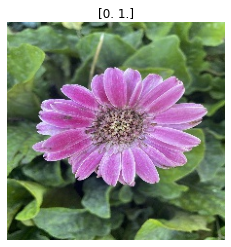

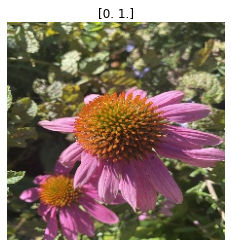

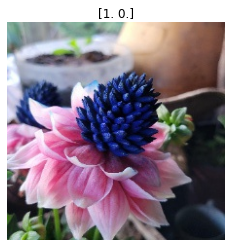

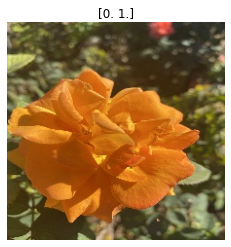

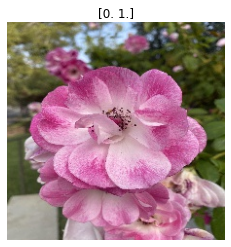

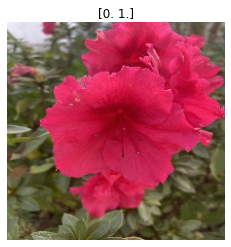

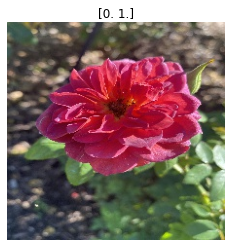

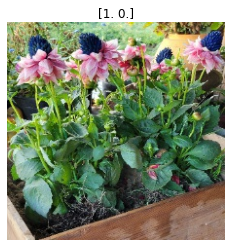

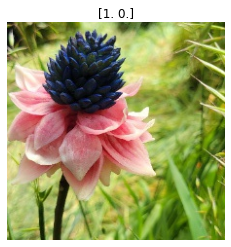

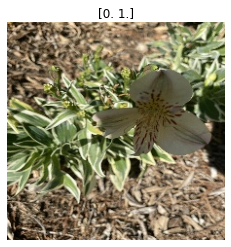

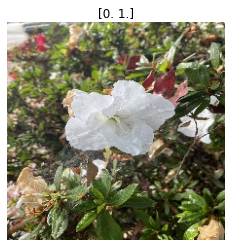

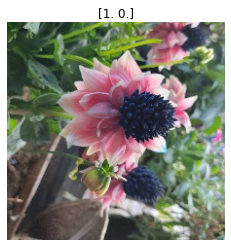

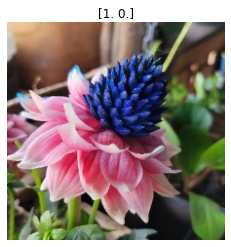

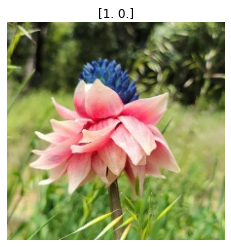

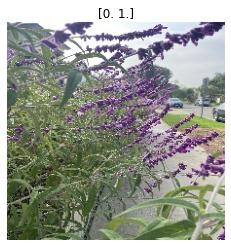

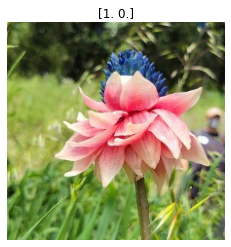

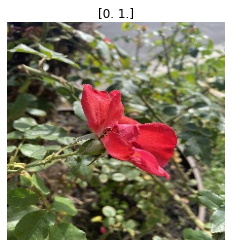

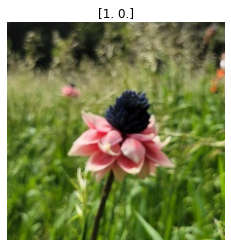

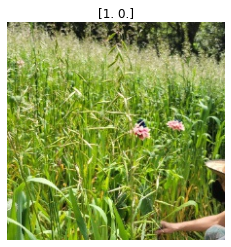

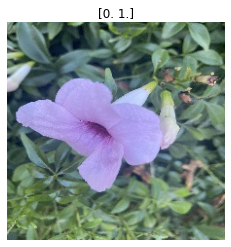

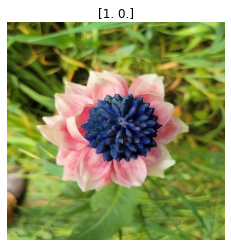

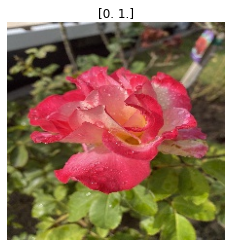

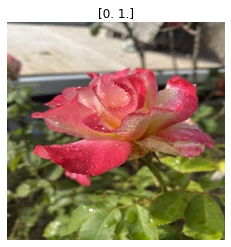

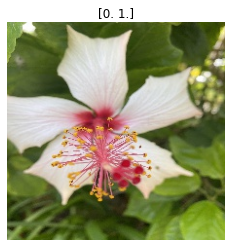

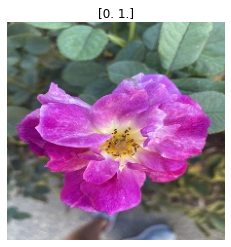

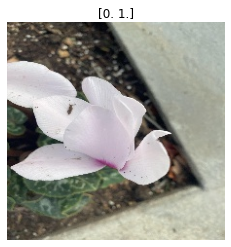

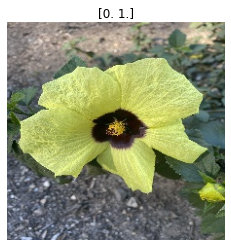

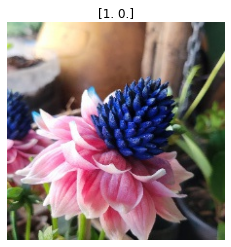

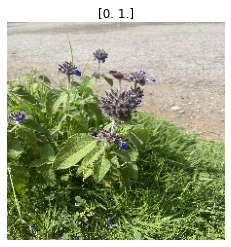

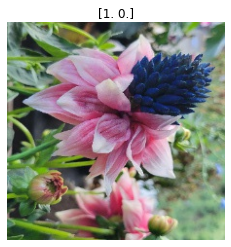

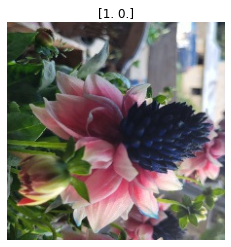

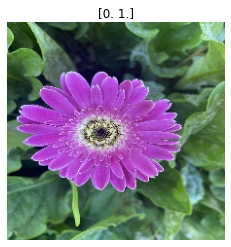

In [6]:
#Let's see flowers for the first batch
batch_1_img = train_dataset[0]
for i in range(0,32):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

In [7]:
experiment = comet_ml.Experiment(
    api_key="y8k3M367nG7VDtHSJERhGKWdQ",
    project_name="cnn-keras", 
    workspace="zenunicorn",
    log_code=True)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, sklearn, tensorflow, tensorboard. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/macbookpro/Desktop/CNN-KERAS' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/zenunicorn/cnn-keras/323df59e08224018b51b5366aba02b60



In [8]:
hyperparams = {
    "batch_size": 32,
    "epochs": 20,
    "num_nodes": 64,
    "activation": 'relu',
    "optimizer": 'adam',
}
experiment.log_parameters(hyperparams)

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [224, 224,3]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation ='softmax')
])

# print model.summary() to preserve automatically in `Output` tab
print(model.summary())

2023-01-10 12:50:49.244519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 64)        16448     
                                                                 
 flatten (Flatten)           (None, 186624)            0

In [10]:
model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

In [11]:
model.fit(train_dataset, batch_size=32, verbose=1, epochs=20, validation_data=validation_dataset, callbacks=callback)

Epoch 1/20
3/3 [==============================] - 6s 1s/step - loss: 4.0578 - accuracy: 0.5185 - val_loss: 2.8844 - val_accuracy: 0.4500
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 1.9026 - accuracy: 0.4444 - val_loss: 0.7127 - val_accuracy: 0.6500
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.6694 - accuracy: 0.6049 - val_loss: 0.6434 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.5650 - accuracy: 0.6049 - val_loss: 0.5585 - val_accuracy: 0.9500
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.4857 - accuracy: 0.8395 - val_loss: 0.5237 - val_accuracy: 0.8500
Epoch 6/20
3/3 [==============================] - 3s 977ms/step - loss: 0.3573 - accuracy: 0.9136 - val_loss: 0.6130 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.2862 - accuracy: 0.9630 - val_loss: 0.4431 - val_accuracy: 0.8500
Epoch 8/20
3/3 [======================

In [12]:
loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

experiment.log_metric("Loss", loss, step=None, include_context=True)
experiment.log_metric("Accuracy", accuracy, step=None, include_context=True)

1/1 [==============================] - 0s 308ms/step - loss: 0.3417 - accuracy: 0.8500
Loss:  0.3417049050331116
Accuracy:  0.8500000238418579


In [14]:
model.save('cnn-model')

INFO:tensorflow:Assets written to: cnn-model/assets


INFO:tensorflow:Assets written to: cnn-model/assets


In [16]:
#We can also log the decision tree classifier parameters.
decision_tree_params ={
     "n_estimators": {
         "type": "discrete",
         "values": [50, 100, 150, 200, 250, 300]
     },
     "criterion": {
         "type": "categorical",
         "values": ["gini", "entropy"]
     },
     "min_samples_leaf": {
         "type": "discrete",
         "values": [1, 2, 3, 4]
     }
}


experiment.log_parameters(decision_tree_params)

In [17]:
# log the model 
experiment.log_model(model, 'cnn-model')

[('.DS_Store',
  {'web': 'https://www.comet.com/api/asset/download?assetId=e822c580deea480e813616f1137b5f5c&experimentKey=323df59e08224018b51b5366aba02b60',
   'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=e822c580deea480e813616f1137b5f5c&experimentKey=323df59e08224018b51b5366aba02b60',
   'assetId': 'e822c580deea480e813616f1137b5f5c'}),
 ('fingerprint.pb',
  {'web': 'https://www.comet.com/api/asset/download?assetId=867c1acd5d3843f38fff212e63e97a09&experimentKey=323df59e08224018b51b5366aba02b60',
   'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=867c1acd5d3843f38fff212e63e97a09&experimentKey=323df59e08224018b51b5366aba02b60',
   'assetId': '867c1acd5d3843f38fff212e63e97a09'}),
 ('keras_metadata.pb',
  {'web': 'https://www.comet.com/api/asset/download?assetId=4dfdaae9270d482d87d7a9272e0c4a68&experimentKey=323df59e08224018b51b5366aba02b60',
   'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=4dfdaae9

In [18]:
#end the experiment
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/zenunicorn/cnn-keras/323df59e08224018b51b5366aba02b60
COMET INFO:   Metrics:
COMET INFO:     Accuracy      : 0.8500000238418579
COMET INFO:     Loss          : 0.3417049050331116
COMET INFO:     test_accuracy : 0.8500000238418579
COMET INFO:     test_loss     : 0.3417049050331116
COMET INFO:   Parameters:
COMET INFO:     activation       : relu
COMET INFO:     batch_size       : 32
COMET INFO:     criterion        : {"type": "categorical", "values": ["gini", "entropy"]}
COMET INFO:     epochs           : 20
COMET INFO:     min_samples_leaf : {"type": "discrete", "values": [1, 2, 3, 4]}
COMET INFO:     n_estimators     : {"type": "discrete", "values": [50, 100, 150, 200, 250, 300]}
COMET INFO:     num_nodes        : 64
COMET INFO:     optimizer   